In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Replace the path if your shortcut is in a different folder
shared_path = "/content/drive/MyDrive/Visualization"

path_a_folder = f"{shared_path}/Path_A_Vis"
path_b_folder = f"{shared_path}/Path_B_Vis"


In [3]:
import os

print("Shared folder:")
print(os.listdir(shared_path))
print("\nPath_A_Vis folder:")
print(os.listdir(path_a_folder))
print("\nPath_B_Vis folder:")
print(os.listdir(path_b_folder))

Shared folder:
['cv_data_full.csv', 'Path_B_Vis', 'Path_A_Vis']

Path_A_Vis folder:
['Copy of model_glove_9prompts_lr2e-4.pt', 'Copy of glove_checkpoint.pt', 'glove.6B.100d.txt']

Path_B_Vis folder:
['model_2_tokenizer.zip', 'model_2_mixed.pt', 'model_1_FROZEN_tokenizer.zip', 'model_1_mixed_FROZEN.pt', 'tfidf_vectorizer.pkl', 'logit_model.pkl', '📘 Model Interpretability Bundle README.gdoc', 'model_2_tokenizer', 'model_1_FROZEN_tokenizer']


In [4]:
import pandas as pd
df = pd.read_csv(f"{shared_path}/cv_data_full.csv")

# Drop rows with missing CV text
df = df.dropna(subset=["CV"]).reset_index(drop=True)

# Optional: preview cleaned data
df.head()


,CV,rewritten_y,Prompt
0,Project of Electron signature Project of Ele...,0,NaN
1,Project Manager From 10.2019 to Present Respo...,1,9.0
2,Achievements in deferent roles: -Was promoted ...,0,NaN
3,Courses: Beetroot Academy «Python for beginner...,1,3.0
4,Tour guiding experience in Europe. Was working...,0,NaN


In [5]:
import joblib

tfidf_vectorizer = joblib.load(f"{path_b_folder}/tfidf_vectorizer.pkl")
logit_model = joblib.load(f"{path_b_folder}/logit_model.pkl")

X_tfidf = tfidf_vectorizer.transform(df["CV"])  # ✅ now this will work


TF-IDF + Logistic Regression Evaluation

              precision    recall  f1-score   support

       Human       0.98      0.99      0.98      3622
         LLM       0.99      0.98      0.98      3616

    accuracy                           0.98      7238
   macro avg       0.98      0.98      0.98      7238
weighted avg       0.98      0.98      0.98      7238



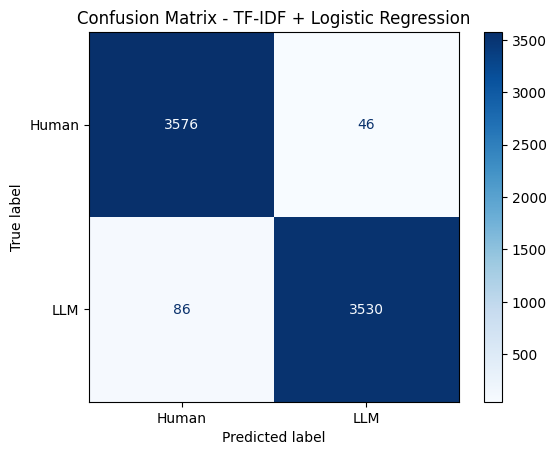

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Actual and predicted labels
y_true = df["rewritten_y"]
y_pred = logit_model.predict(X_tfidf)

# Print classification report
print("TF-IDF + Logistic Regression Evaluation\n")
print(classification_report(y_true, y_pred, target_names=["Human", "LLM"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human", "LLM"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - TF-IDF + Logistic Regression")
plt.grid(False)
plt.show()


In [20]:
import numpy as np

# Load GloVe 100d vectors
glove_path = f"{path_a_folder}/glove.6B.100d.txt"

glove_100d = {}
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        glove_100d[word] = vector

print("Loaded GloVe vectors:", len(glove_100d))
print("Sample vector dim:", glove_100d["the"].shape)


Loaded GloVe vectors: 400000
Sample vector dim: (100,)


In [21]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')

def get_avg_glove_vector(text, glove_dict, dim=100):
    tokens = word_tokenize(str(text).lower())
    vecs = [glove_dict[word] for word in tokens if word in glove_dict]
    if not vecs:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

X_glove_100d = np.vstack([get_avg_glove_vector(text, glove_100d) for text in df["CV"]])


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [22]:
import torch.nn as nn
import torch

# Define architecture matching the checkpoint
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=100):
        super(MLPClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64),  # 0
            nn.ReLU(),                 # 1
            nn.Dropout(0.1),           # 2
            nn.Linear(64, 32),         # 3
            nn.ReLU(),                 # 4
            nn.Dropout(0.1),           # 5
            nn.Linear(32, 2)           # 6
        )

    def forward(self, x):
        return self.classifier(x)

# Load model and weights
glove_model = MLPClassifier(input_dim=100)
state_dict = torch.load(f"{path_a_folder}/Copy of model_glove_9prompts_lr2e-4.pt", map_location="cpu")
glove_model.load_state_dict(state_dict)
glove_model.eval()


MLPClassifier(
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [23]:
import torch.nn as nn

class MLPClassifier(nn.Module):
    def __init__(self, input_dim=100):
        super(MLPClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64),  # 0
            nn.ReLU(),                 # 1
            nn.Dropout(0.1),           # 2
            nn.Linear(64, 32),         # 3
            nn.ReLU(),                 # 4
            nn.Dropout(0.1),           # 5
            nn.Linear(32, 2)           # 6
        )

    def forward(self, x):
        return self.classifier(x)


GloVe + MLP (100d) Evaluation

              precision    recall  f1-score   support

       Human       0.75      0.94      0.83      3622
         LLM       0.92      0.68      0.78      3616

    accuracy                           0.81      7238
   macro avg       0.83      0.81      0.81      7238
weighted avg       0.83      0.81      0.81      7238



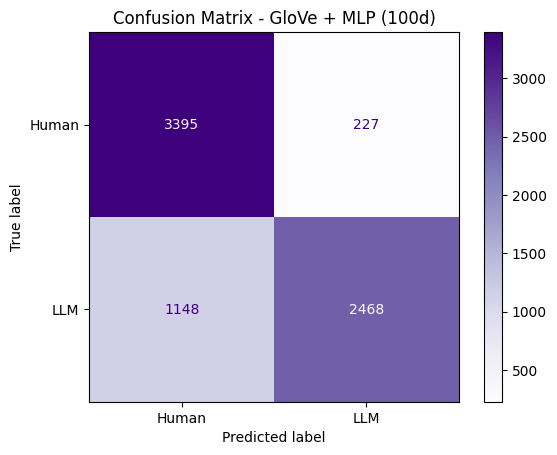

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Inference
X_tensor = torch.tensor(X_glove_100d, dtype=torch.float32)

with torch.no_grad():
    logits = glove_model(X_tensor)
    y_pred_glove = torch.argmax(logits, dim=1).numpy()

# Evaluation
y_true = df["rewritten_y"]

print("GloVe + MLP (100d) Evaluation\n")
print(classification_report(y_true, y_pred_glove, target_names=["Human", "LLM"]))

cm = confusion_matrix(y_true, y_pred_glove)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human", "LLM"])
disp.plot(cmap="Purples")
plt.title("Confusion Matrix - GloVe + MLP (100d)")
plt.grid(False)
plt.show()


In [25]:
print(df.columns.tolist())


['CV', 'rewritten_y', 'prompt']


In [26]:
df.rename(columns={"Prompt": "prompt"}, inplace=True)  # Adjust the name if needed


In [27]:
df["y_pred_glove"] = y_pred_glove


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-17-f465938393d4>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=prompt_df, x="prompt", y="f1", palette="viridis")


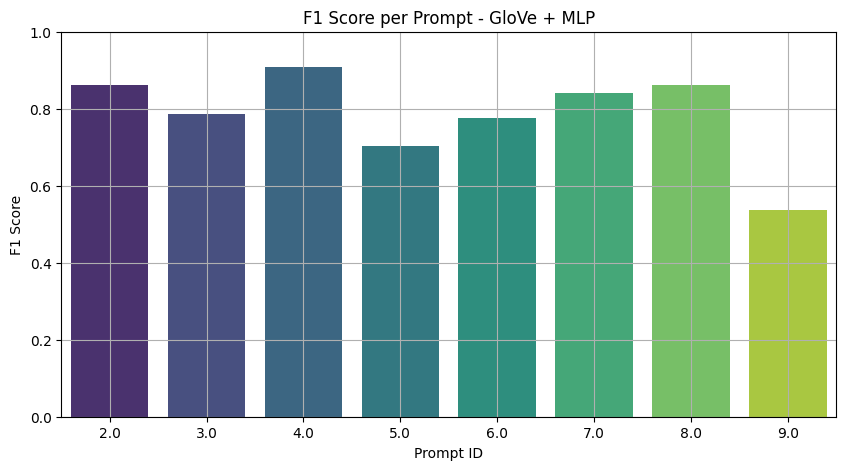

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

prompt_stats = []
for prompt in sorted(df["prompt"].unique()):
    subset = df[df["prompt"] == prompt]
    acc = accuracy_score(subset["rewritten_y"], subset["y_pred_glove"])
    f1 = f1_score(subset["rewritten_y"], subset["y_pred_glove"])
    prompt_stats.append({"prompt": prompt, "accuracy": acc, "f1": f1})

prompt_df = pd.DataFrame(prompt_stats)

plt.figure(figsize=(10, 5))
sns.barplot(data=prompt_df, x="prompt", y="f1", palette="viridis")
plt.title("F1 Score per Prompt - GloVe + MLP")
plt.ylabel("F1 Score")
plt.xlabel("Prompt ID")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


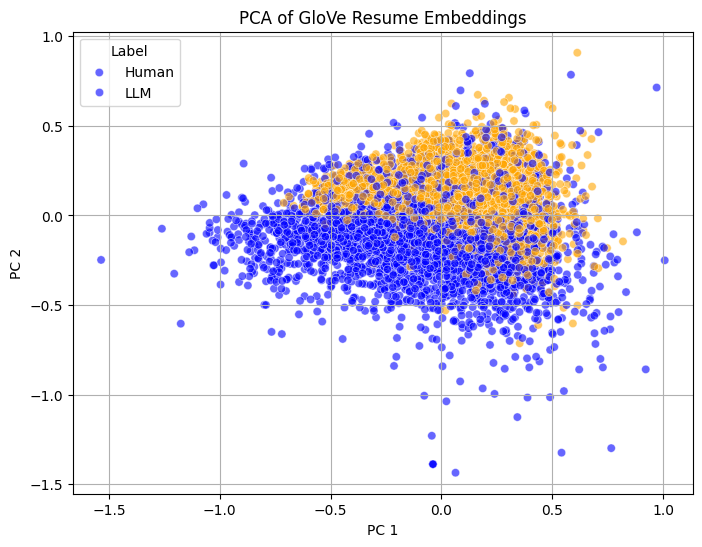

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_glove_100d)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df["rewritten_y"], palette=["blue", "orange"], alpha=0.6)
plt.title("PCA of GloVe Resume Embeddings")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(title="Label", labels=["Human", "LLM"])
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for prompt in sorted(df["prompt"].unique()):
    subset = df[df["prompt"] == prompt]

    if subset.empty:
        continue  # Skip prompts with no data

    y_true = subset["rewritten_y"]
    y_pred = subset["y_pred_glove"]

    if len(np.unique(y_true)) < 2 or len(np.unique(y_pred)) < 2:
        print(f"Skipping Prompt {prompt} (only one class present)")
        continue  # Confusion matrix needs both classes

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human", "LLM"])
    disp.plot(cmap="magma")
    plt.title(f"Confusion Matrix - Prompt {prompt}")
    plt.grid(False)
    plt.show()


Skipping Prompt 2.0 (only one class present)
Skipping Prompt 3.0 (only one class present)
Skipping Prompt 4.0 (only one class present)
Skipping Prompt 5.0 (only one class present)
Skipping Prompt 6.0 (only one class present)
Skipping Prompt 7.0 (only one class present)
Skipping Prompt 8.0 (only one class present)
Skipping Prompt 9.0 (only one class present)


In [7]:
!pip install shap --quiet
import shap


In [ ]:
# Wrap model to work with SHAP (outputs probability of LLM class)
def model_predict_glove(X_numpy):
    X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
    with torch.no_grad():
        logits = glove_model(X_tensor)
        probs = torch.nn.functional.softmax(logits, dim=1).numpy()
    return probs


In [ ]:
import numpy as np

# Choose a background and evaluation sample set
background = X_glove_100d[np.random.choice(X_glove_100d.shape[0], 100, replace=False)]
explainer = shap.Explainer(model_predict_glove, background)

# Pick a prompt to explain (e.g., prompt 4)
prompt_to_explain = 4
subset = df[df["prompt"] == prompt_to_explain].copy()
X_explain = np.vstack([get_avg_glove_vector(text, glove_100d) for text in subset["CV"]])

# Generate SHAP values
shap_values = explainer(X_explain)


PermutationExplainer explainer: 310it [00:38,  8.10it/s]                         


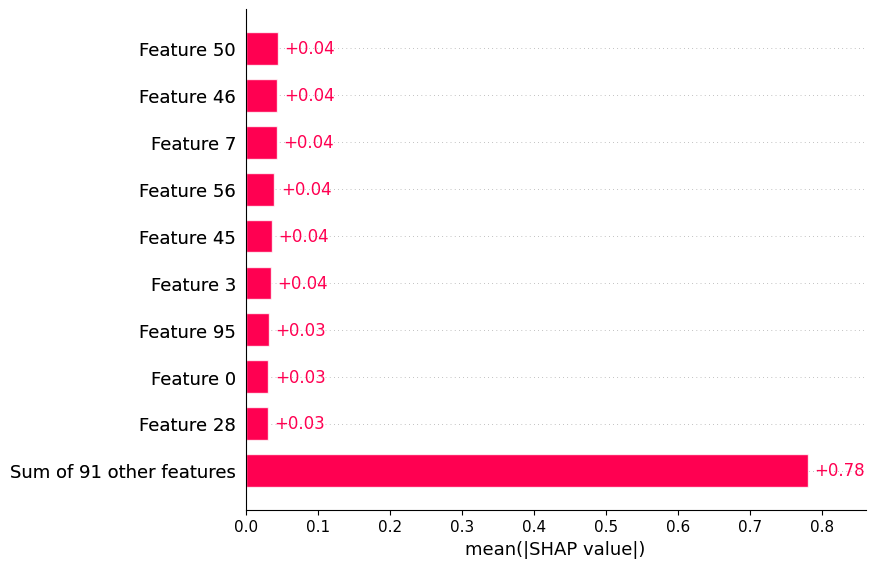

In [ ]:
shap.plots.bar(shap_values[:, :, 1], max_display=10)  # Class 1 = LLM


In [ ]:
from nltk.tokenize import word_tokenize
from collections import defaultdict

# Build SHAP-like contribution per word
word_shap = defaultdict(list)

for i, text in enumerate(subset["CV"]):  # subset should already be filtered to prompt 4
    tokens = word_tokenize(str(text).lower())
    token_vecs = [glove_100d[word] for word in tokens if word in glove_100d]

    if not token_vecs:
        continue

    # Avg GloVe vector for this sample
    avg_vec = np.mean(token_vecs, axis=0)

    # SHAP values for this sample
    shap_vec = shap_values[i, :, 1].values  # class 1 = LLM

    # Distribute SHAP over words proportionally
    for word in tokens:
        if word in glove_100d:
            vec = glove_100d[word]
            weight = np.dot(vec, shap_vec) / (np.linalg.norm(vec) * np.linalg.norm(shap_vec) + 1e-8)
            word_shap[word].append(weight)


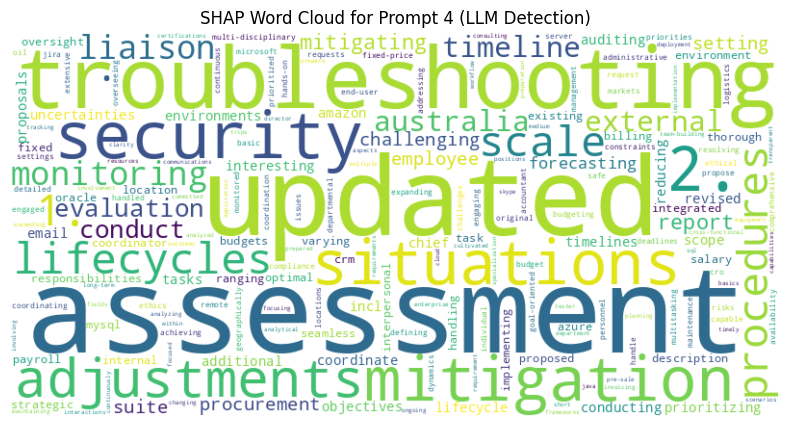

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Average SHAP impact per word
word_scores = {word: np.mean(vals) for word, vals in word_shap.items() if len(vals) > 2}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_scores)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("SHAP Word Cloud for Prompt 4 (LLM Detection)")
plt.show()


In [ ]:
def shap_word_cloud_for_prompt(prompt_id, df, glove_dict, shap_explainer, max_words=100):
    from collections import defaultdict
    from nltk.tokenize import word_tokenize
    from wordcloud import WordCloud

    subset = df[df["prompt"] == prompt_id].copy()
    if subset.empty:
        print(f"No samples for prompt {prompt_id}")
        return

    # Recompute GloVe avg vectors (for safety)
    X_explain = np.vstack([get_avg_glove_vector(text, glove_dict) for text in subset["CV"]])
    shap_values = shap_explainer(X_explain)

    # Token-level SHAP attribution
    word_shap = defaultdict(list)
    for i, text in enumerate(subset["CV"]):
        tokens = word_tokenize(str(text).lower())
        token_vecs = [glove_dict[word] for word in tokens if word in glove_dict]
        if not token_vecs:
            continue
        shap_vec = shap_values[i, :, 1].values
        for word in tokens:
            if word in glove_dict:
                vec = glove_dict[word]
                weight = np.dot(vec, shap_vec) / (np.linalg.norm(vec) * np.linalg.norm(shap_vec) + 1e-8)
                word_shap[word].append(weight)

    word_scores = {w: np.mean(v) for w, v in word_shap.items() if len(v) > 2}
    if not word_scores:
        print(f"No valid SHAP values for prompt {prompt_id}")
        return

    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=max_words).generate_from_frequencies(word_scores)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"SHAP Word Cloud for Prompt {prompt_id} (LLM Detection)")
    plt.show()


PermutationExplainer explainer: 310it [00:21,  7.97it/s]                         


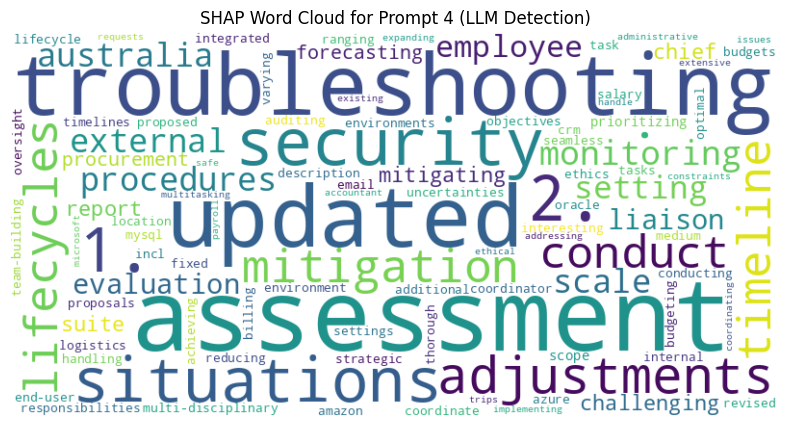

In [ ]:
shap_word_cloud_for_prompt(4, df, glove_100d, explainer)


In [ ]:
class DistilBERT_MLP(nn.Module):
    def __init__(self, hidden_size=768):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),  # classifier.0
            nn.ReLU(),                    # classifier.1
            nn.Dropout(0.1),              # classifier.2
            nn.Linear(256, 256),          # classifier.3
            nn.ReLU(),                    # classifier.4
            nn.Dropout(0.1),              # classifier.5
            nn.Linear(256, 2)             # classifier.6
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # shape: [batch, seq_len, hidden]
        pooled = (hidden_states * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True)  # mean pooling
        return self.classifier(pooled)


In [ ]:
model_2 = DistilBERT_MLP()
model_2.load_state_dict(torch.load(os.path.join(model_2_folder, "model_2_mixed.pt"), map_location="cpu"))
model_2.eval()


DistilBERT_MLP(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

# Tokenize all resumes in df["CV"]
cv_texts = df["CV"].astype(str).tolist()

encoding = tokenizer_2(
    cv_texts,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)

# Prepare DataLoader for batching
input_ids = encoding["input_ids"]
attention_mask = encoding["attention_mask"]
dataset = TensorDataset(input_ids, attention_mask)
loader = DataLoader(dataset, batch_size=32)

# Run inference + capture pooled embeddings and predictions
all_logits = []
all_preds = []
all_embeddings = []

model_2.eval()

with torch.no_grad():
    for batch in tqdm(loader, desc="Running DistilBERT inference"):
        ids, mask = batch
        outputs = model_2.bert(input_ids=ids, attention_mask=mask)
        hidden = outputs.last_hidden_state  # [batch, seq_len, hidden]
        pooled = (hidden * mask.unsqueeze(-1)).sum(1) / mask.sum(1, keepdim=True)  # mean pooling

        logits = model_2.classifier(pooled)
        preds = torch.argmax(F.softmax(logits, dim=1), dim=1)

        all_logits.append(logits)
        all_preds.append(preds)
        all_embeddings.append(pooled)

# Final outputs
y_pred_model2 = torch.cat(all_preds).numpy()
X_bert_pooled = torch.cat(all_embeddings).numpy()  # Shape: (N, 768)


Running DistilBERT inference: 100%|██████████| 227/227 [56:41<00:00, 14.98s/it]


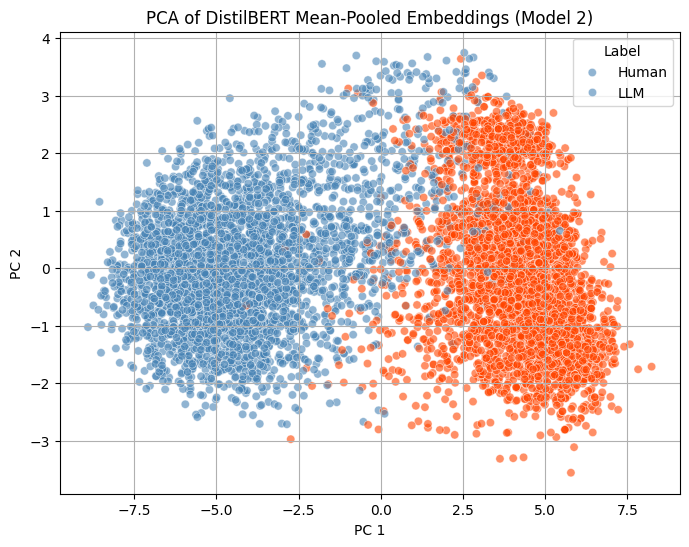

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_bert_pooled)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=df["rewritten_y"],
    palette=["steelblue", "orangered"],
    alpha=0.6
)
plt.title("PCA of DistilBERT Mean-Pooled Embeddings (Model 2)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(title="Label", labels=["Human", "LLM"])
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


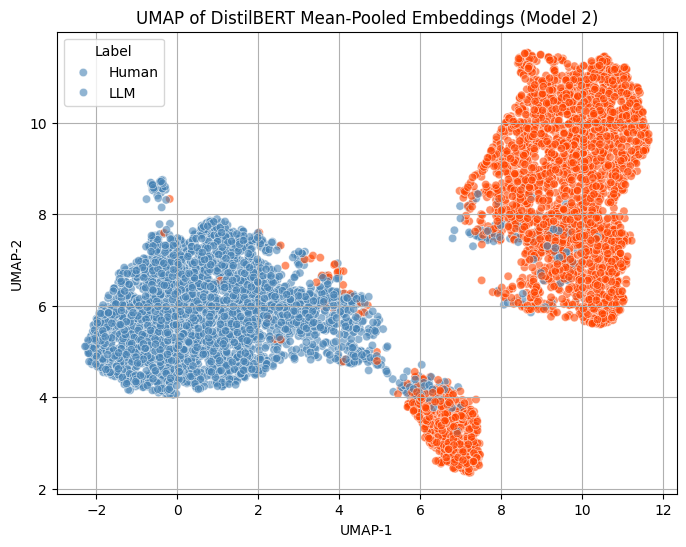

In [ ]:
import umap.umap_ as umap

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_bert_pooled)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_umap[:, 0], y=X_umap[:, 1],
    hue=df["rewritten_y"],
    palette=["steelblue", "orangered"],
    alpha=0.6
)
plt.title("UMAP of DistilBERT Mean-Pooled Embeddings (Model 2)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Label", labels=["Human", "LLM"])
plt.grid(True)
plt.show()


In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoModel, AutoTokenizer

In [ ]:
def get_token_importance(text, model, tokenizer):
    model.eval()

    # Tokenize input
    enc = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    input_ids = enc["input_ids"]
    attention_mask = enc["attention_mask"]

    # Get embeddings and retain gradient
    embeddings = model.bert.embeddings(input_ids)
    embeddings.retain_grad()  # ✅ This makes .grad non-None

    # Forward through BERT
    outputs = model.bert(inputs_embeds=embeddings, attention_mask=attention_mask)
    hidden_states = outputs.last_hidden_state
    pooled = (hidden_states * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True)
    logits = model.classifier(pooled)

    # Backprop on logit for LLM class (index 1)
    logit = logits[0, 1]
    logit.backward()

    # Compute norm of gradients at each token
    grads = embeddings.grad[0].norm(dim=1)  # shape: [seq_len]
    grads = grads / (grads.max() + 1e-8)    # normalize to 0–1

    # Get token strings
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    return tokens, grads.detach().cpu().numpy()


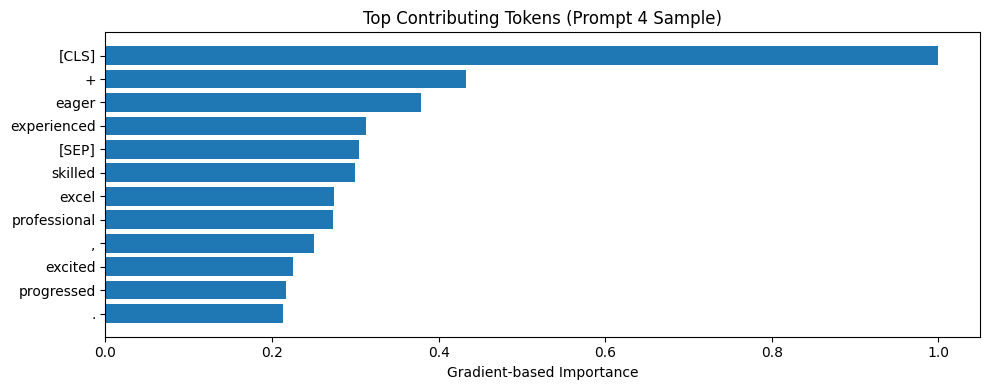

In [ ]:
sample_text = df[df["prompt"] == 4]["CV"].astype(str).sample(1, random_state=4).iloc[0]
tokens, scores = get_token_importance(sample_text, model_2, tokenizer_2)

# Plot top contributing tokens
topk = 15
sorted_idx = np.argsort(scores)[-topk:]
plt.figure(figsize=(10, 4))
plt.barh([tokens[i] for i in sorted_idx], [scores[i] for i in sorted_idx])
plt.title("Top Contributing Tokens (Prompt 4 Sample)")
plt.xlabel("Gradient-based Importance")
plt.tight_layout()
plt.show()


In [ ]:
def plot_token_importance(prompt_id, topk=15, random_state=42):
    """
    Visualizes top token attributions for a single sample from a given prompt using input gradients.

    Args:
        prompt_id (int): The prompt number to sample from.
        topk (int): Number of top tokens to display.
        random_state (int): For reproducibility.

    Output:
        Matplotlib bar chart of token importances.
    """
    # Sample a text
    sample_text = df[df["prompt"] == prompt_id]["CV"].astype(str).sample(1, random_state=random_state).iloc[0]

    # Get token attributions
    tokens, scores = get_token_importance(sample_text, model_2, tokenizer_2)

    # Sort by importance
    sorted_idx = np.argsort(scores)[-topk:]
    top_tokens = [tokens[i] for i in sorted_idx]
    top_scores = [scores[i] for i in sorted_idx]

    # Plot
    plt.figure(figsize=(10, 4))
    plt.barh(top_tokens, top_scores)
    plt.title(f"Top Contributing Tokens (Prompt {prompt_id} Sample)")
    plt.xlabel("Gradient-based Importance")
    plt.tight_layout()
    plt.show()


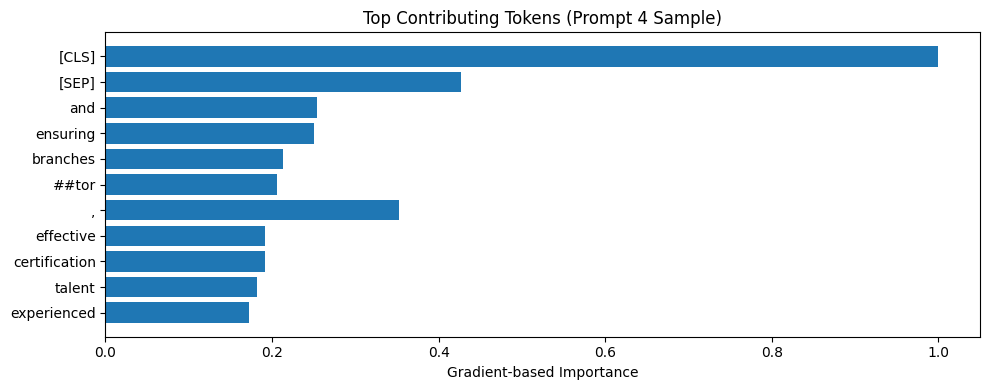

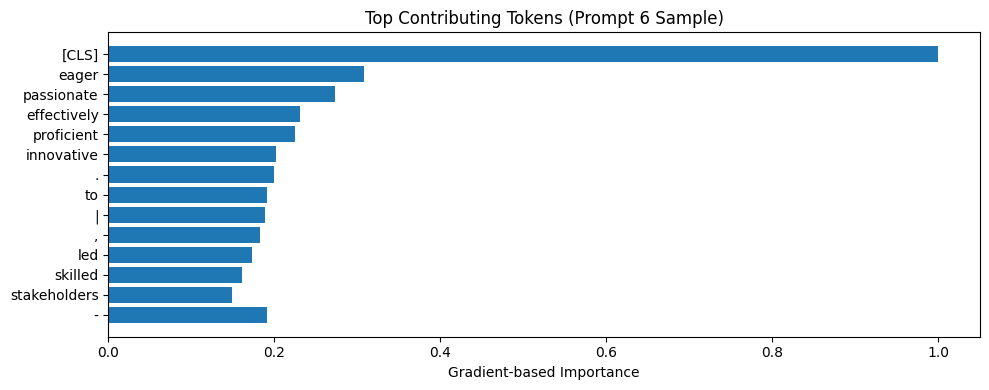

In [ ]:
plot_token_importance(4)
plot_token_importance(6)


In [6]:
import torch.nn as nn
from transformers import DistilBertModel

class DistilBERT_MLP(nn.Module):
    def __init__(self, layer_dims, activations, freeze_layers):
        super().__init__()

        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")

        if freeze_layers:
            for param in self.bert.parameters():
                param.requires_grad = False

        # Build MLP classifier based on layer_dims and activations
        layers = []
        for i in range(len(layer_dims) - 1):
            layers.append(nn.Linear(layer_dims[i], layer_dims[i+1]))
            if i < len(activations):
                act = activations[i].lower()
                if act == "relu":
                    layers.append(nn.ReLU())
                elif act == "gelu":
                    layers.append(nn.GELU())
            if i < len(layer_dims) - 2:
                layers.append(nn.Dropout(0.1))
        self.classifier = nn.Sequential(*layers)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        pooled = (hidden_states * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True)
        return self.classifier(pooled)


In [9]:
model_3 = DistilBERT_MLP(
    layer_dims=[768, 512, 256, 2],
    activations=['GELU', 'ReLU'],
    freeze_layers=False
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [10]:
# Load tokenizer for frozen model
from transformers import DistilBertTokenizerFast

tokenizer_3 = DistilBertTokenizerFast.from_pretrained("/content/drive/MyDrive/Visualization/Path_B_Vis/model_1_FROZEN_tokenizer")

# Load model weights
model_3.load_state_dict(torch.load("/content/drive/MyDrive/Visualization/Path_B_Vis/model_1_mixed_FROZEN.pt", map_location="cpu"))
model_3.eval()


DistilBERT_MLP(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(

In [11]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Tokenize CV texts
texts = df["CV"].astype(str).tolist()
encodings = tokenizer_3(
    texts,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)

# Create DataLoader
dataset = TensorDataset(encodings["input_ids"], encodings["attention_mask"])
loader = DataLoader(dataset, batch_size=32)

# Collect pooled embeddings
pooled_embeddings = []

with torch.no_grad():
    for batch in tqdm(loader, desc="Model 3 Inference"):
        ids, mask = batch
        output = model_3.bert(input_ids=ids, attention_mask=mask)
        hidden = output.last_hidden_state
        pooled = (hidden * mask.unsqueeze(-1)).sum(1) / mask.sum(1, keepdim=True)
        pooled_embeddings.append(pooled)

X_model3_pooled = torch.cat(pooled_embeddings).numpy()  # shape (N, 768)


Model 3 Inference: 100%|██████████| 227/227 [56:39<00:00, 14.98s/it]


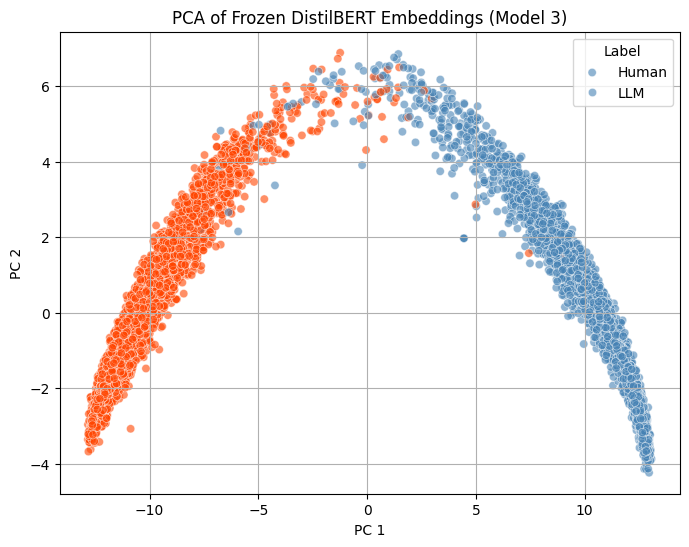

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
X_pca_3 = pca.fit_transform(X_model3_pooled)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca_3[:, 0], y=X_pca_3[:, 1],
    hue=df["rewritten_y"],
    palette=["steelblue", "orangered"],
    alpha=0.6
)
plt.title("PCA of Frozen DistilBERT Embeddings (Model 3)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(title="Label", labels=["Human", "LLM"])
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


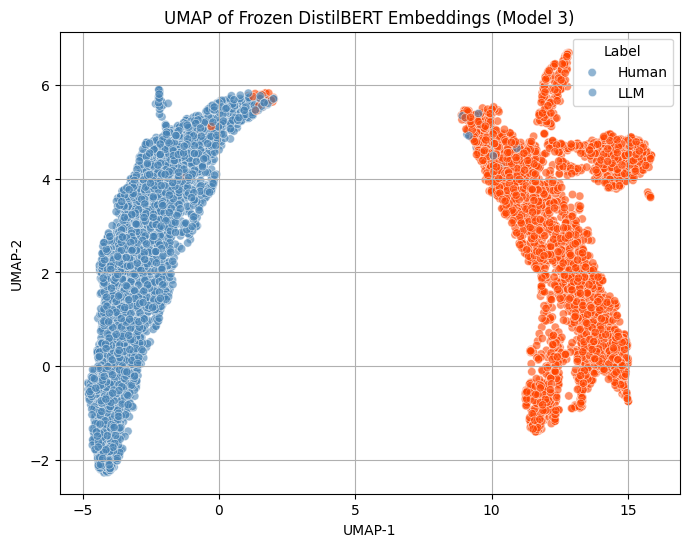

In [13]:
import umap.umap_ as umap

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap_3 = umap_model.fit_transform(X_model3_pooled)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_umap_3[:, 0], y=X_umap_3[:, 1],
    hue=df["rewritten_y"],
    palette=["steelblue", "orangered"],
    alpha=0.6
)
plt.title("UMAP of Frozen DistilBERT Embeddings (Model 3)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Label", labels=["Human", "LLM"])
plt.grid(True)
plt.show()


In [14]:
def get_token_importance(text, model, tokenizer):
    model.eval()

    enc = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    input_ids = enc["input_ids"]
    attention_mask = enc["attention_mask"]

    # Get embeddings and retain gradients
    embeddings = model.bert.embeddings(input_ids)
    embeddings.retain_grad()

    # Forward
    outputs = model.bert(inputs_embeds=embeddings, attention_mask=attention_mask)
    hidden_states = outputs.last_hidden_state
    pooled = (hidden_states * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True)
    logits = model.classifier(pooled)

    # Backward on LLM logit
    logit = logits[0, 1]
    logit.backward()

    # Gradients
    grads = embeddings.grad[0].norm(dim=1)
    grads = grads / (grads.max() + 1e-8)

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    return tokens, grads.detach().cpu().numpy()


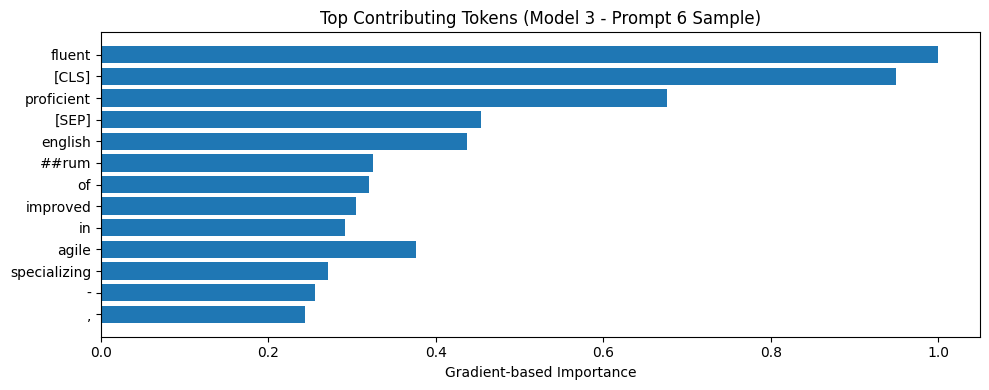

In [28]:
sample_text = df[df["prompt"] == 6]["CV"].astype(str).sample(1, random_state=11).iloc[0]
tokens, scores = get_token_importance(sample_text, model_3, tokenizer_3)

# Plot
topk = 15
sorted_idx = np.argsort(scores)[-topk:]
plt.figure(figsize=(10, 4))
plt.barh([tokens[i] for i in sorted_idx], [scores[i] for i in sorted_idx])
plt.title("Top Contributing Tokens (Model 3 - Prompt 6 Sample)")
plt.xlabel("Gradient-based Importance")
plt.tight_layout()
plt.show()
